# Machine Learning in Python - Project 1

Due Friday, April 15th by 5 pm UK local time.

*include contributors names here*

## 0. Setup

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

##missingness library
import missingno

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

In [53]:
# Load data
d = pd.read_csv("../hotel.csv")
d.head()

##create copy of data
df = d.copy()

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

**The paper states that no missing data is present**. Specifically, they mention that Null of "Missing" data in the company and agent category are actually their own category specifying that no company or agent was used. As such we will create a new category for these.

In [54]:
missing_cols = ["company", "agent"]
for i in missing_cols:
    df[i] = df[i].astype('object') ##Change to object for categorical classification
    df[i] = df[i].fillna("Not Used") ##Fill "NA" with new variable

##create new variable for agent used and company used
binary_cols = ["company_used", "agent_used"]
for i in range(len(binary_cols)):
    df[binary_cols[i]] = np.where(df[missing_cols[i]]!= 'Not Used', 1, 0)

Removing duplicates: There is the slight chance that two different bookings have the exat same data since we are not given a customer ID. However, since the data includes lead_time, arrival_date_year, arrival_date_week_number, and other very specific identifying characteristics, we can be confident that any duplicates are actual duplicates and not two different customers with the same data

In [55]:
##drop duplicates
df = df.drop_duplicates(keep = 'first')

In [28]:
##check unique values of strings to see if any strings are formatted weird
# uniquevals = {}
# for col in d.select_dtypes(["object", "bool"]):
#     uniquevals[col] = d[col].unique()
    
# print(uniquevals)

{'hotel': array(['Resort Hotel', 'City Hotel'], dtype=object), 'arrival_date_month': array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object), 'meal': array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object), 'country': array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', nan, 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'N

In [56]:
df.columns
df.dtypes

is_canceled                         int64
hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

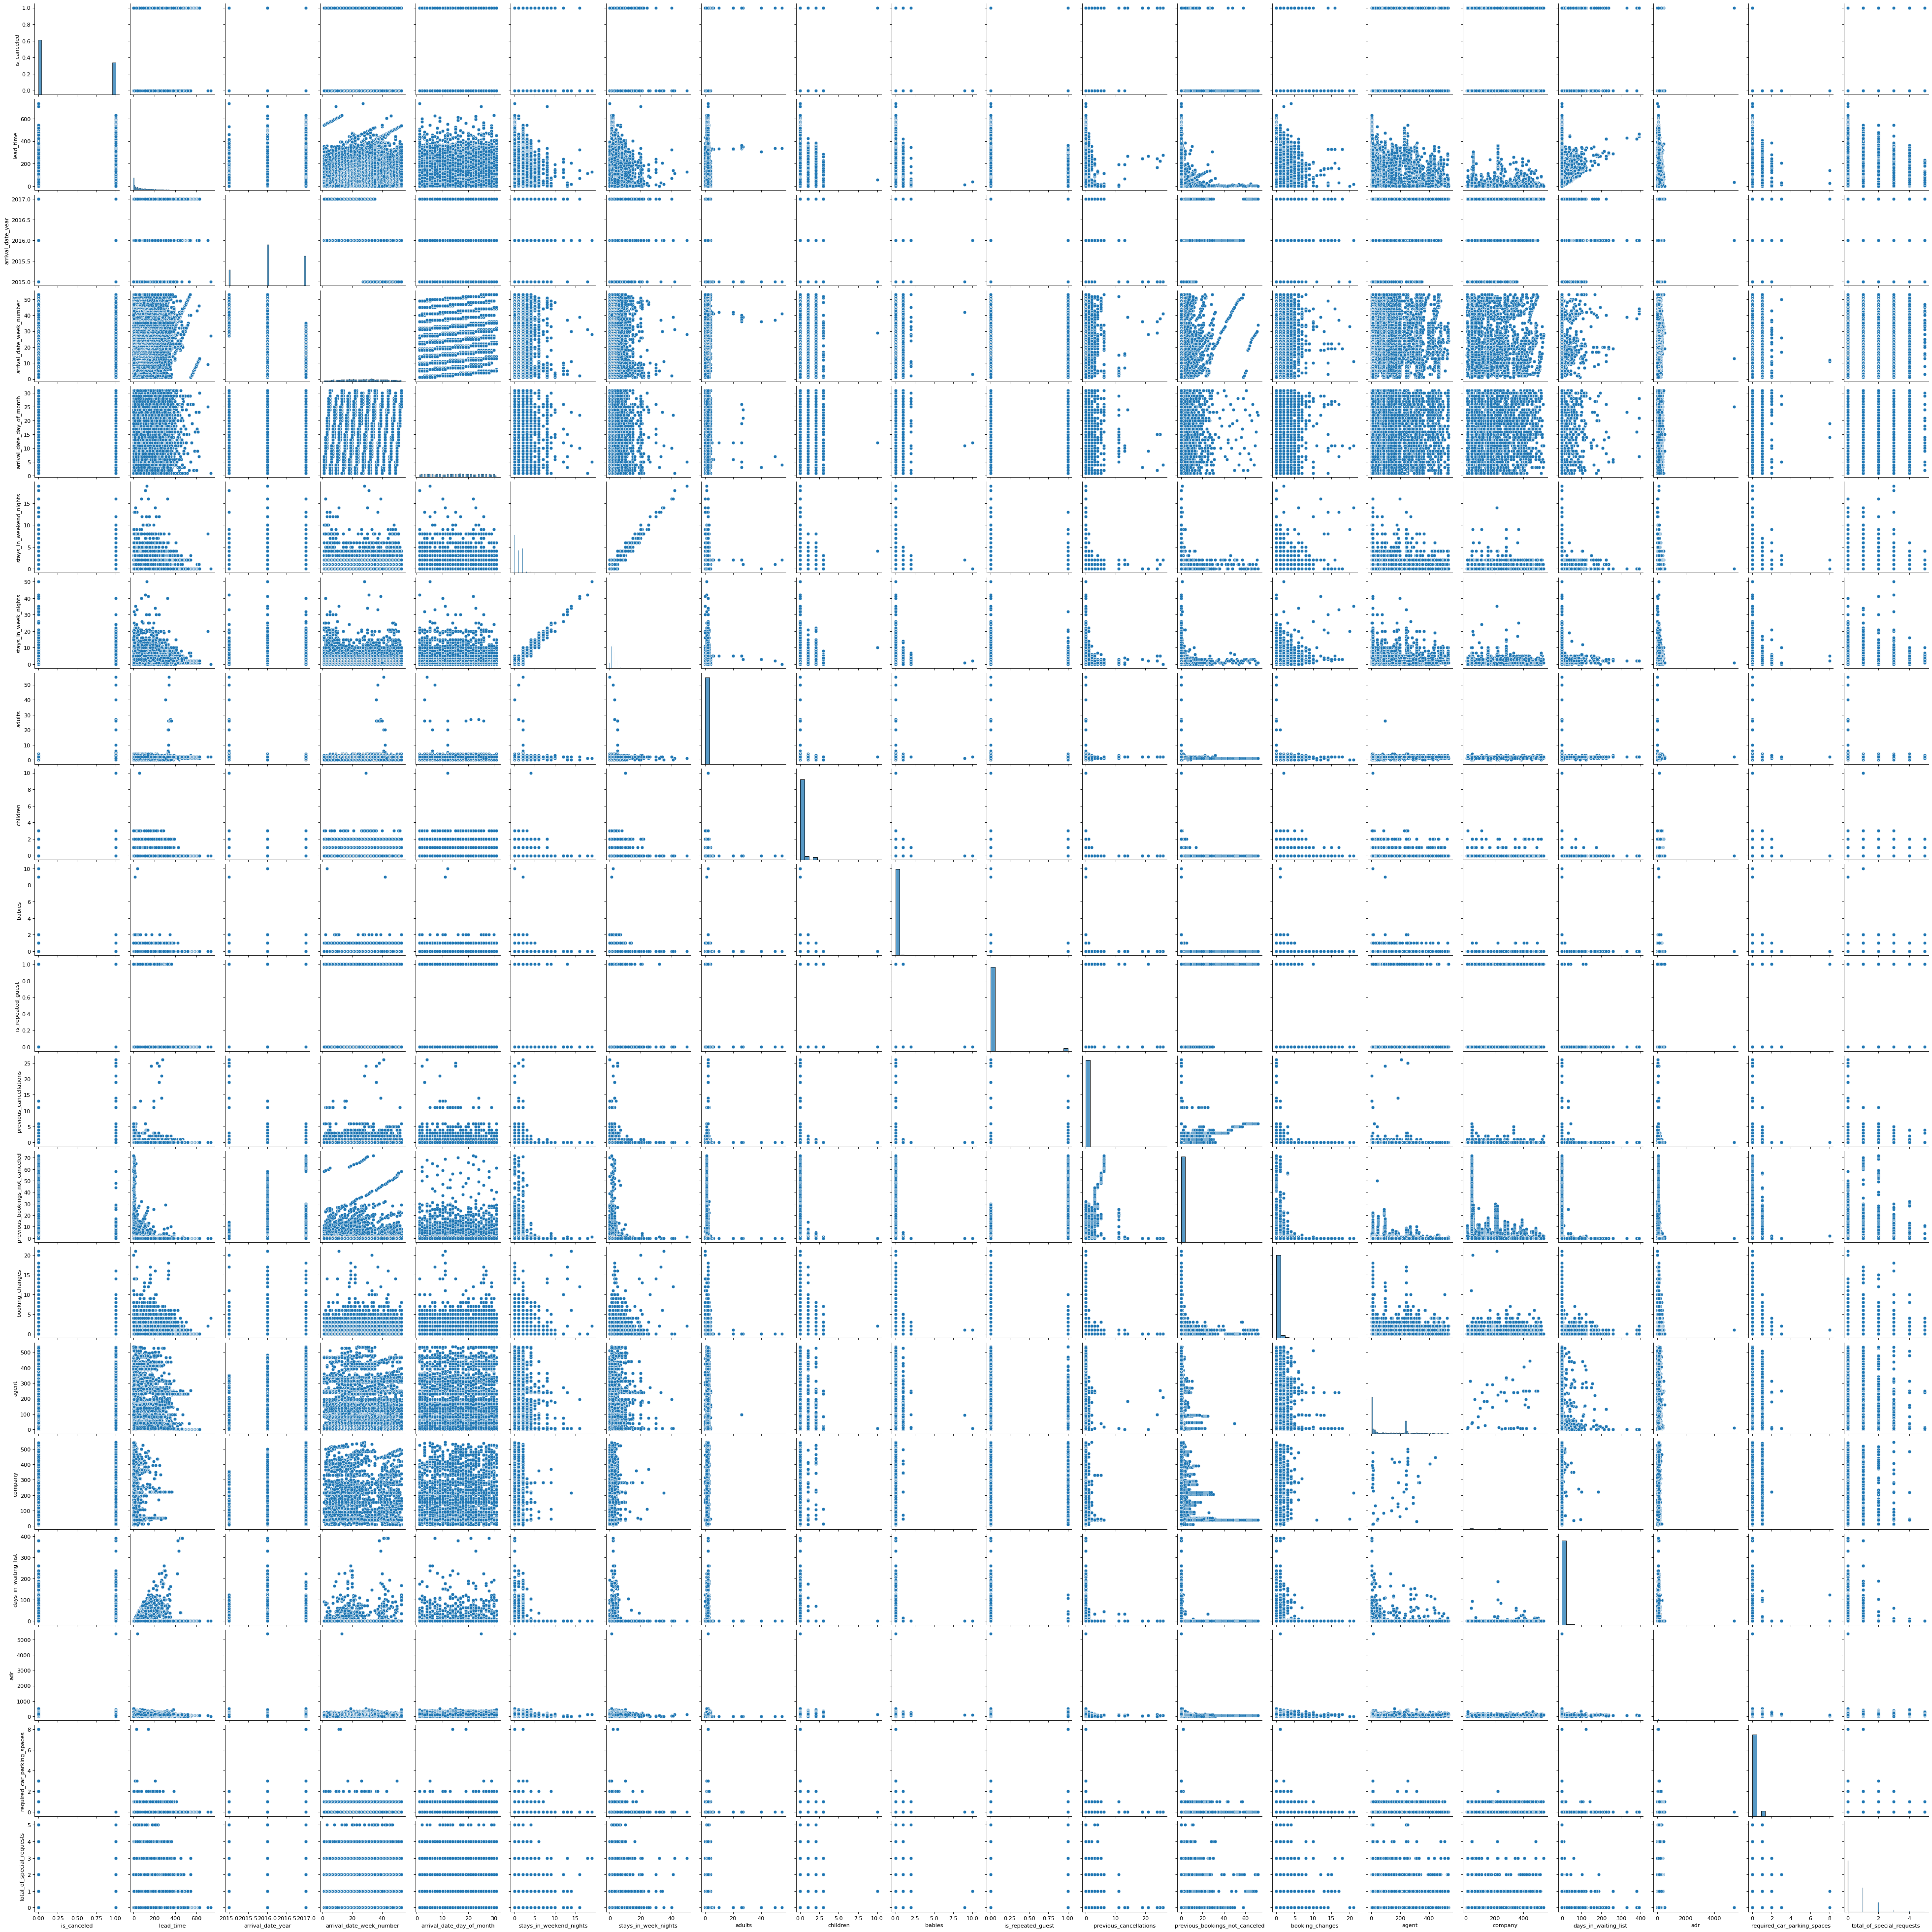

In [39]:
sns.pairplot(df)

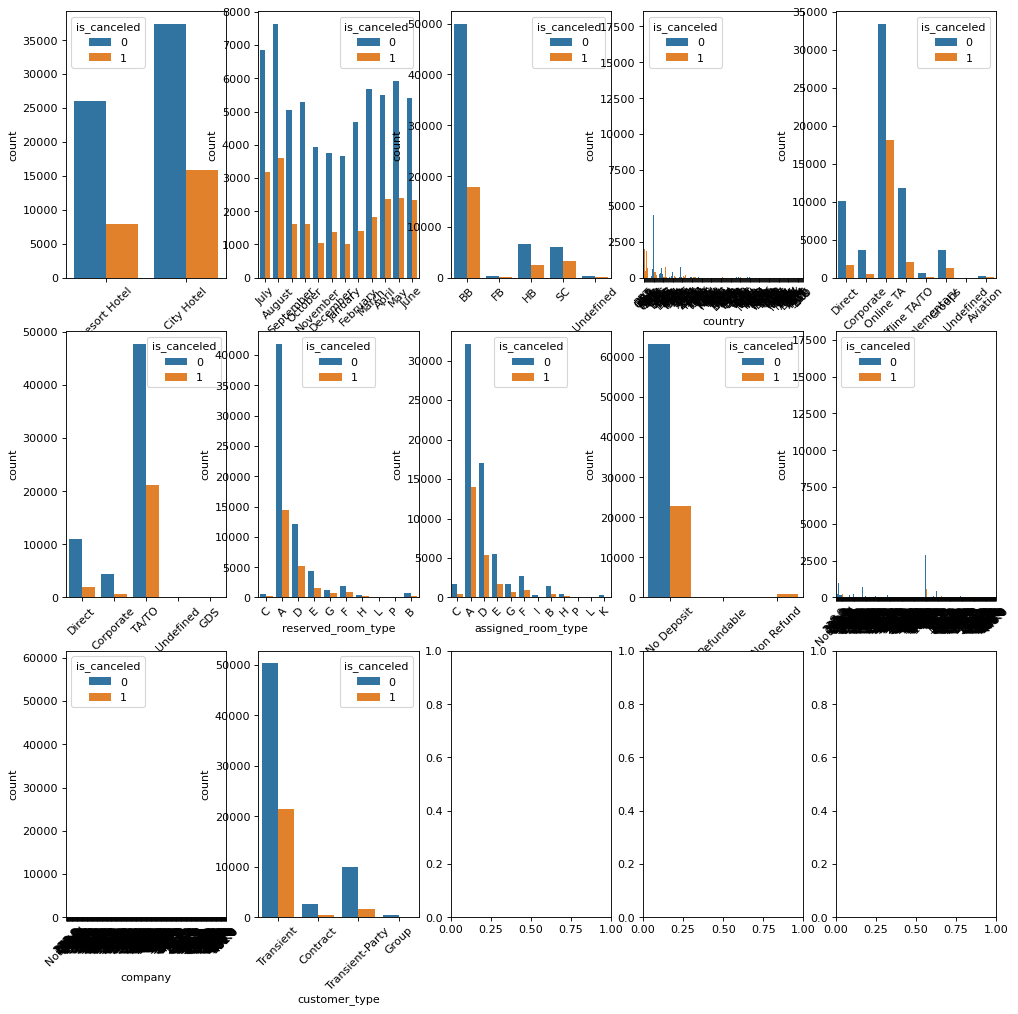

In [57]:
fig, ax = plt.subplots(ncols = 5, nrows =3, figsize = (15, 15))
ax = ax.ravel()
obj_cols = df.select_dtypes(["object", "bool"]).columns 

for i in range(len(obj_cols)):
    g = sns.countplot(x=obj_cols[i], hue = "is_canceled", data = df, ax = ax[i])
    for item in g.get_xticklabels():
        item.set_rotation(45)
    g
    

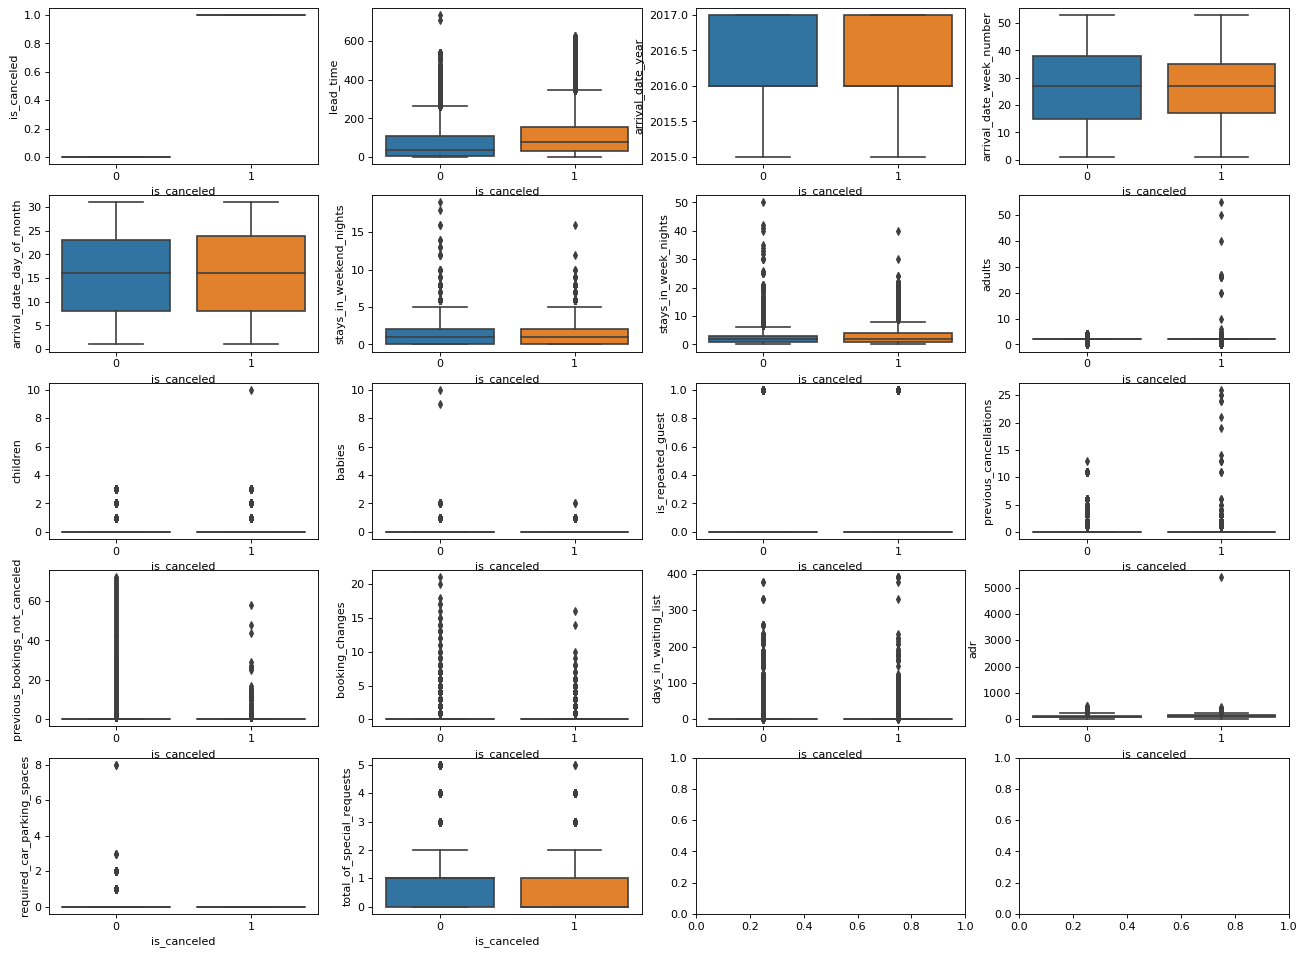

In [58]:
fig, ax2 = plt.subplots(ncols = 4, nrows =5, figsize = (20, 15))
ax2 = ax2.ravel()
num_cols = df.select_dtypes(["int64", "float64"]).columns 

for i in range(len(num_cols)):
    sns.boxplot(y=num_cols[i], x = "is_canceled", data = df, ax = ax2[i])

Missing Data Patterns:


is_canceled                         0
hotel                               0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           451
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                               0
company                             0
days_in_waiting_list                0
customer_typ

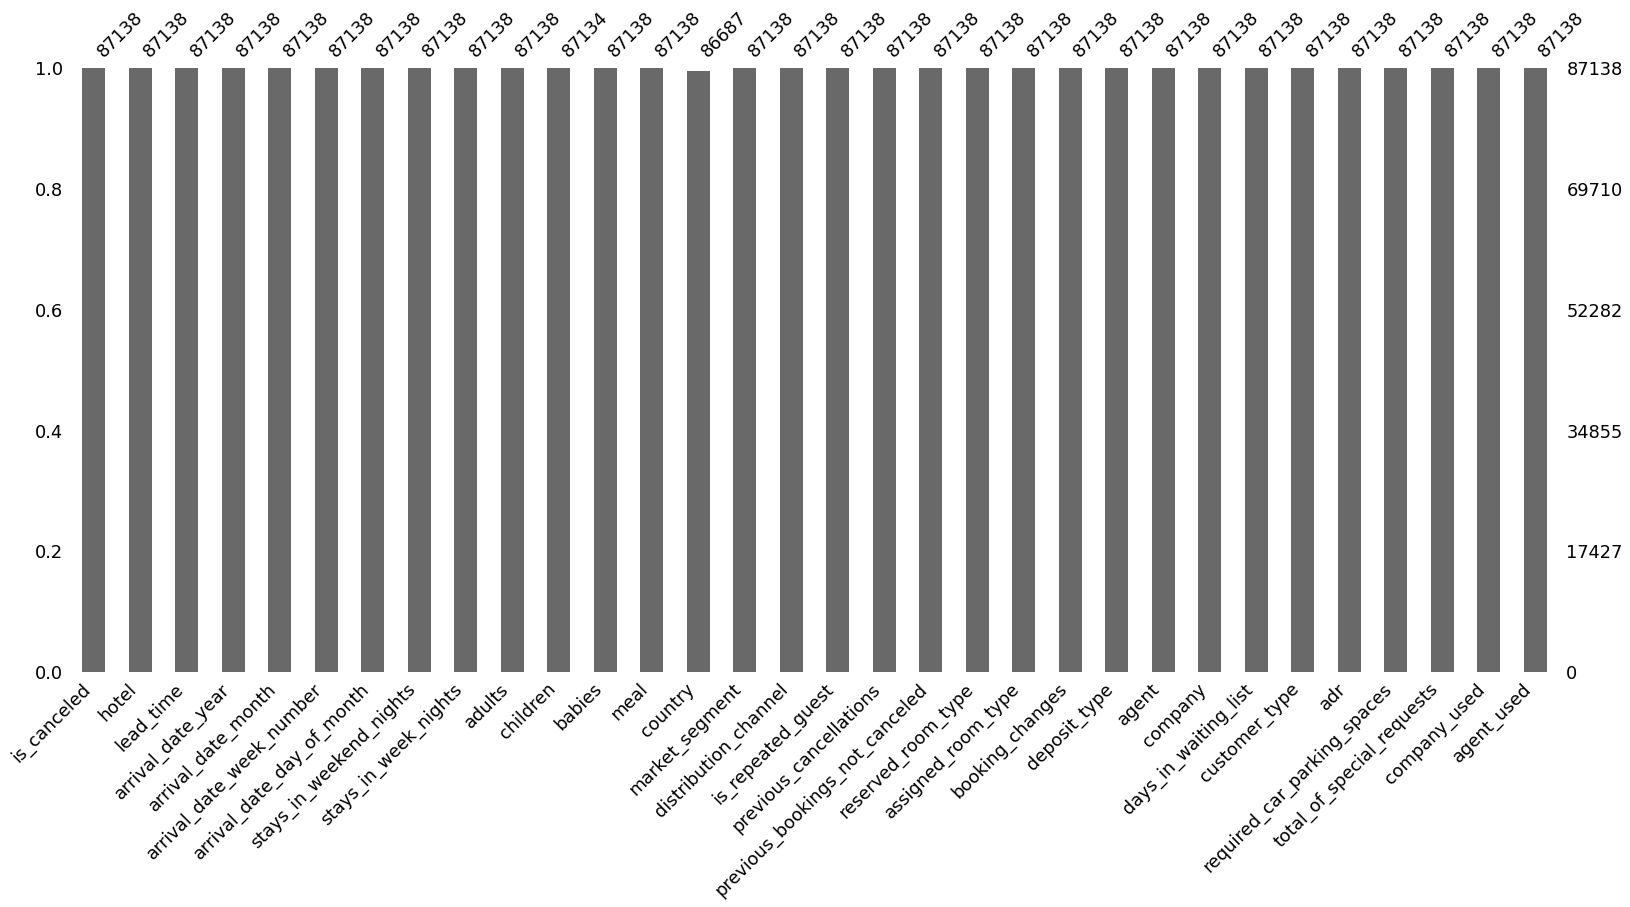

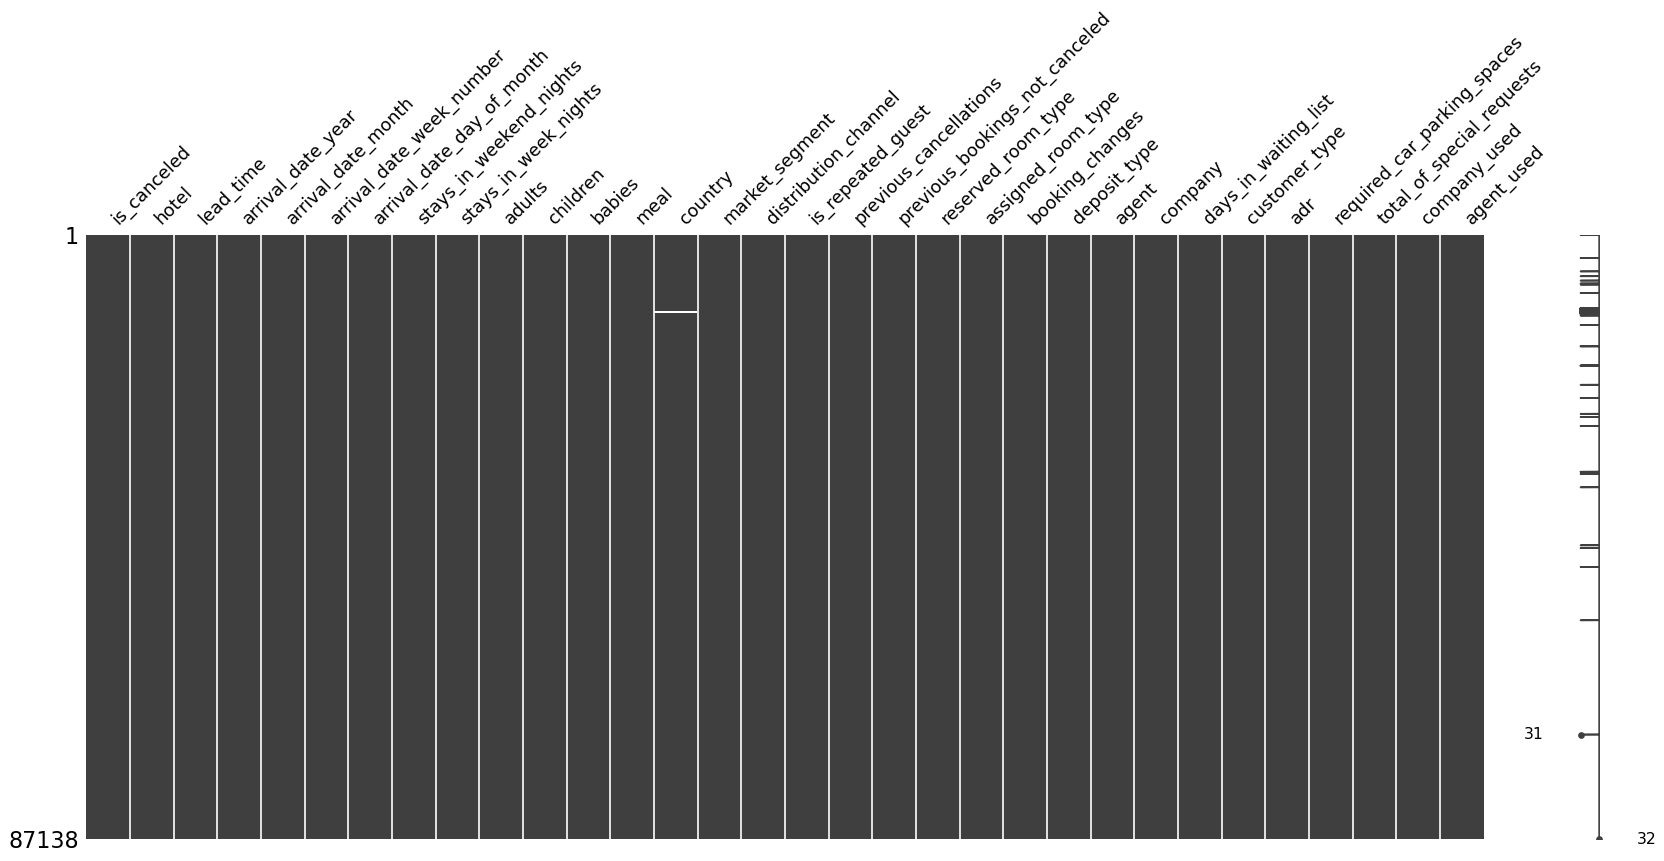

In [59]:
print("Missing Data Patterns:")
# sns.heatmap(d.isna(), cbar=False)
plt.show()
missingno.bar(df)
missingno.matrix(df)
df.isna().sum()
# missingno.heatmap(df)

<!-- Using LabelEncoder below to convert factors to ordered levels to check for correlations. For the machine learning step we will need to use dummy/indicator variables instead of ordered factors, but here we wish to visualize the correlation without too many features. -->

<AxesSubplot:>

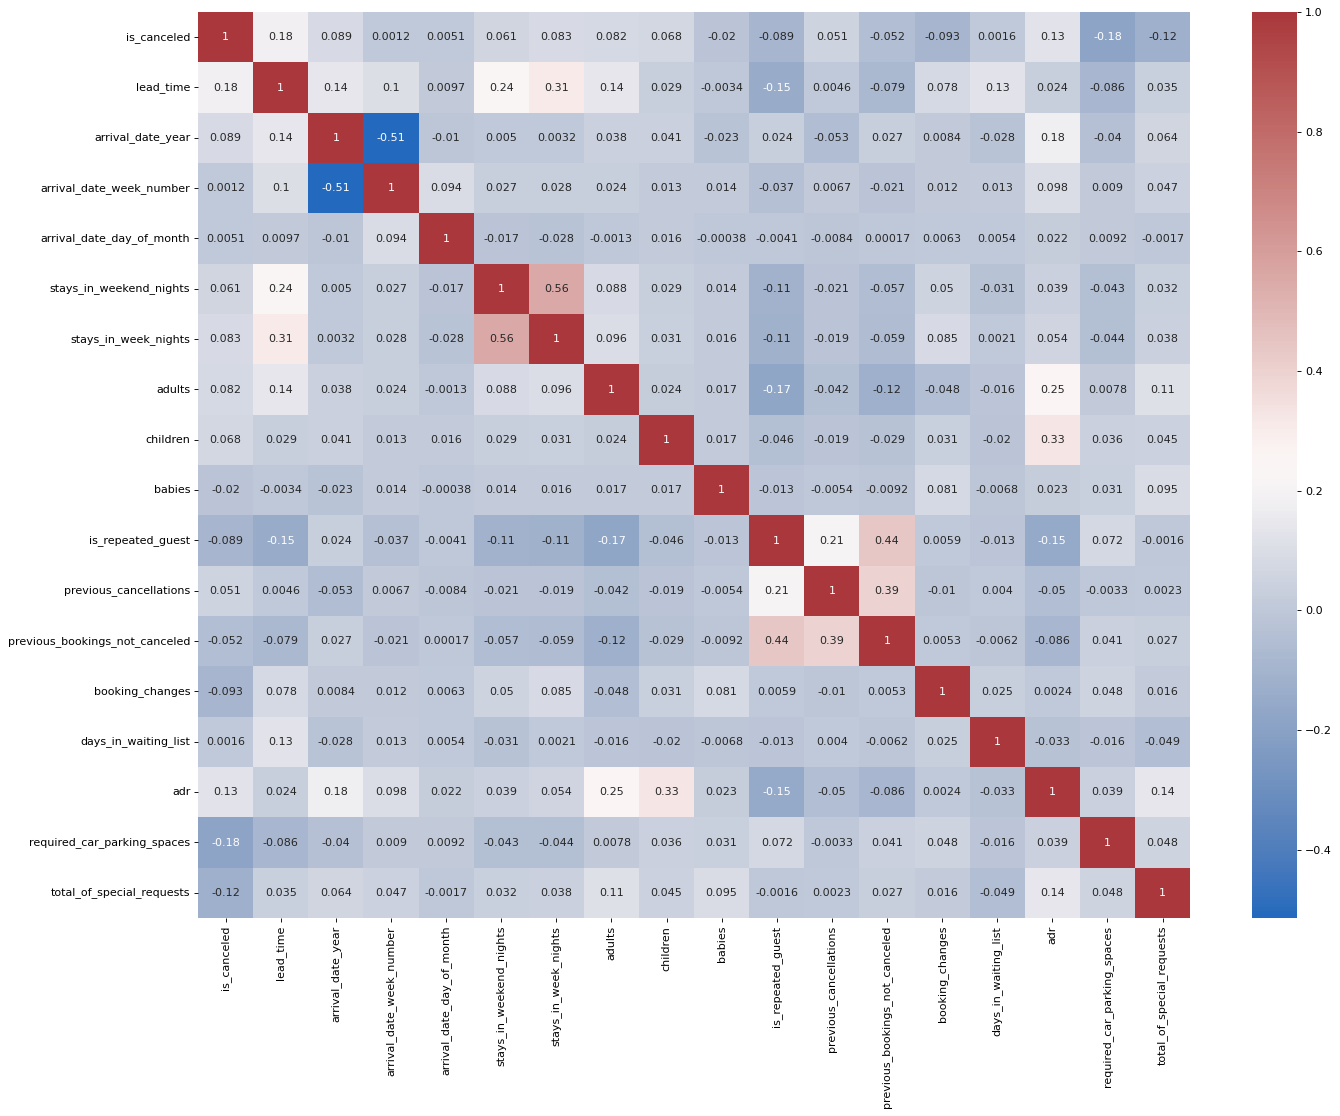

In [62]:
##correlation between numerical featuresONLY
# from sklearn.preprocessing import LabelEncoder

# df_labelencode = df.copy()
# le = LabelEncoder()

# for col in obj_cols:
#     df_labelencode[col] = le.fit_transform(df_labelencode[col])
plt.figure(figsize=(20, 15))
sns.heatmap(df.select_dtypes(["int64", "float64"]).corr(), annot = True, cmap = "vlag")
# sns.heatmap(df_labelencode.corr(), annot=True, cmap = "vlag");

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*